# 特徴量密度コーパス設計 (jvs002 / parallel100)

このノートでは、03で作成した音素ベースの解析結果と、02で抽出した F0 / メル特徴量を統合し、
各文の **「音素＋F0＋メル」をまとめた特徴量密度スコア** を計算して、
TTS 学習に使う少量コーパス候補（例: 上位10文）を決めます。


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# プロジェクトルート（notebooks/ から実行されることを想定）
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "jvs_ver1" / "jvs_ver1"
OUTPUT_ROOT = PROJECT_ROOT / "outputs"

SPEAKER_ID = "jvs002"

# 03 で保存した音素ベース解析結果
CORPUS_ANALYSIS_PATH = OUTPUT_ROOT / "corpus_analysis" / SPEAKER_ID / "corpus_analysis.csv"

# 02 で保存した特徴量 (mel / f0)
FEATURE_ROOT = OUTPUT_ROOT / "features" / SPEAKER_ID / "parallel100"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CORPUS_ANALYSIS_PATH exists:", CORPUS_ANALYSIS_PATH.exists())
print("FEATURE_ROOT exists:", FEATURE_ROOT.exists())


PROJECT_ROOT: /mnt/c/dev/minimal-feature-corpus-tts
CORPUS_ANALYSIS_PATH exists: True
FEATURE_ROOT exists: True


In [2]:
# 1. 03の解析結果を読み込む

corpus_df = pd.read_csv(CORPUS_ANALYSIS_PATH)

# 念のため id を文字列として扱う
corpus_df['id'] = corpus_df['id'].astype(str)
corpus_df.set_index('id', inplace=False)

print("corpus_df shape:", corpus_df.shape)
print("corpus_df columns:", list(corpus_df.columns))
print("\nHead:")
print(corpus_df.head(5)[['id', 'num_phones', 'num_unique_phones', 'rare_phone_count', 'info_score']])


corpus_df shape: (100, 11)
corpus_df columns: ['id', 'text', 'phones', 'num_phones', 'unique_phones', 'num_unique_phones', 'rare_phone_count', 'diversity', 'avg_phone_freq', 'info_score', 'new_phones_if_selected']

Head:
                    id  num_phones  num_unique_phones  rare_phone_count  \
0  VOICEACTRESS100_001          75                 20                 1   
1  VOICEACTRESS100_002          88                 24                 2   
2  VOICEACTRESS100_003          68                 20                 2   
3  VOICEACTRESS100_004          62                 20                 1   
4  VOICEACTRESS100_005         115                 26                 0   

   info_score  
0    0.266667  
1    0.545455  
2    0.588235  
3    0.322581  
4    0.000000  


In [3]:
# 2. mel / f0 特徴量の要約統計を計算

from typing import Dict

mel_stats_list = []
f0_stats_list = []

mel_files = sorted(FEATURE_ROOT.glob("*_mel.npy"))
print("Num mel files:", len(mel_files))

for mel_path in mel_files:
    base = mel_path.stem.replace("_mel", "")  # VOICEACTRESS100_XXX
    mel = np.load(mel_path)

    # mel: (n_mels, T) 想定
    mel_mean = float(mel.mean())
    mel_std = float(mel.std())
    # フレームごとのエネルギー（各フレームの平均）
    frame_energy = mel.mean(axis=0)
    mel_energy_mean = float(frame_energy.mean())
    mel_energy_std = float(frame_energy.std())

    mel_stats_list.append({
        "id": base,
        "mel_mean": mel_mean,
        "mel_std": mel_std,
        "mel_energy_mean": mel_energy_mean,
        "mel_energy_std": mel_energy_std,
    })

    # F0
    f0_path = FEATURE_ROOT / f"{base}_f0.npy"
    if f0_path.exists():
        f0 = np.load(f0_path)
        # 有声区間のみ（>0 かつ有限）
        mask = np.isfinite(f0) & (f0 > 0)
        if mask.any():
            f0_valid = f0[mask]
            f0_mean = float(f0_valid.mean())
            f0_std = float(f0_valid.std())
            f0_min = float(f0_valid.min())
            f0_max = float(f0_valid.max())
            f0_range = f0_max - f0_min
        else:
            f0_mean = f0_std = f0_range = np.nan
        f0_stats_list.append({
            "id": base,
            "f0_mean": f0_mean,
            "f0_std": f0_std,
            "f0_range": f0_range,
        })

mel_df = pd.DataFrame(mel_stats_list)
f0_df = pd.DataFrame(f0_stats_list)

print("mel_df shape:", mel_df.shape)
print("f0_df shape:", f0_df.shape)
print("\nmel_df head:")
print(mel_df.head(5))
print("\nf0_df head:")
print(f0_df.head(5))


Num mel files: 100
mel_df shape: (100, 5)
f0_df shape: (100, 4)

mel_df head:
                    id   mel_mean    mel_std  mel_energy_mean  mel_energy_std
0  VOICEACTRESS100_001 -58.040180  18.552517       -58.040180       12.385857
1  VOICEACTRESS100_002 -60.112453  17.989429       -60.112453       12.639763
2  VOICEACTRESS100_003 -58.647675  18.307022       -58.647678       12.752596
3  VOICEACTRESS100_004 -59.771690  18.258429       -59.771694       13.337421
4  VOICEACTRESS100_005 -61.898232  17.178911       -61.898235       12.243763

f0_df head:
                    id     f0_mean      f0_std    f0_range
0  VOICEACTRESS100_001  203.846510   94.869035  450.000000
1  VOICEACTRESS100_002  200.852827   95.609175  385.929529
2  VOICEACTRESS100_003  200.248113   91.396717  418.537814
3  VOICEACTRESS100_004  196.628907  105.283431  450.000000
4  VOICEACTRESS100_005  189.339946   96.823805  434.424762


In [4]:
# 3. corpus_df と mel/f0 特徴量をマージ

# id をキーにマージ
feat_df = corpus_df.copy()
feat_df = feat_df.merge(mel_df, on='id', how='left')
feat_df = feat_df.merge(f0_df, on='id', how='left')

print("feat_df shape:", feat_df.shape)
print("\nColumns:")
print(list(feat_df.columns))

# 簡単な欠損確認
print("\nMissing counts (mel/f0 related):")
print(feat_df[["mel_std", "mel_energy_std", "f0_std", "f0_range"]].isna().sum())


feat_df shape: (100, 18)

Columns:
['id', 'text', 'phones', 'num_phones', 'unique_phones', 'num_unique_phones', 'rare_phone_count', 'diversity', 'avg_phone_freq', 'info_score', 'new_phones_if_selected', 'mel_mean', 'mel_std', 'mel_energy_mean', 'mel_energy_std', 'f0_mean', 'f0_std', 'f0_range']

Missing counts (mel/f0 related):
mel_std           0
mel_energy_std    0
f0_std            0
f0_range          0
dtype: int64


Correlation (subset):
mel_std           0.203476
mel_energy_std    0.056480
f0_std            0.113885
f0_range         -0.042991
Name: info_score, dtype: float64


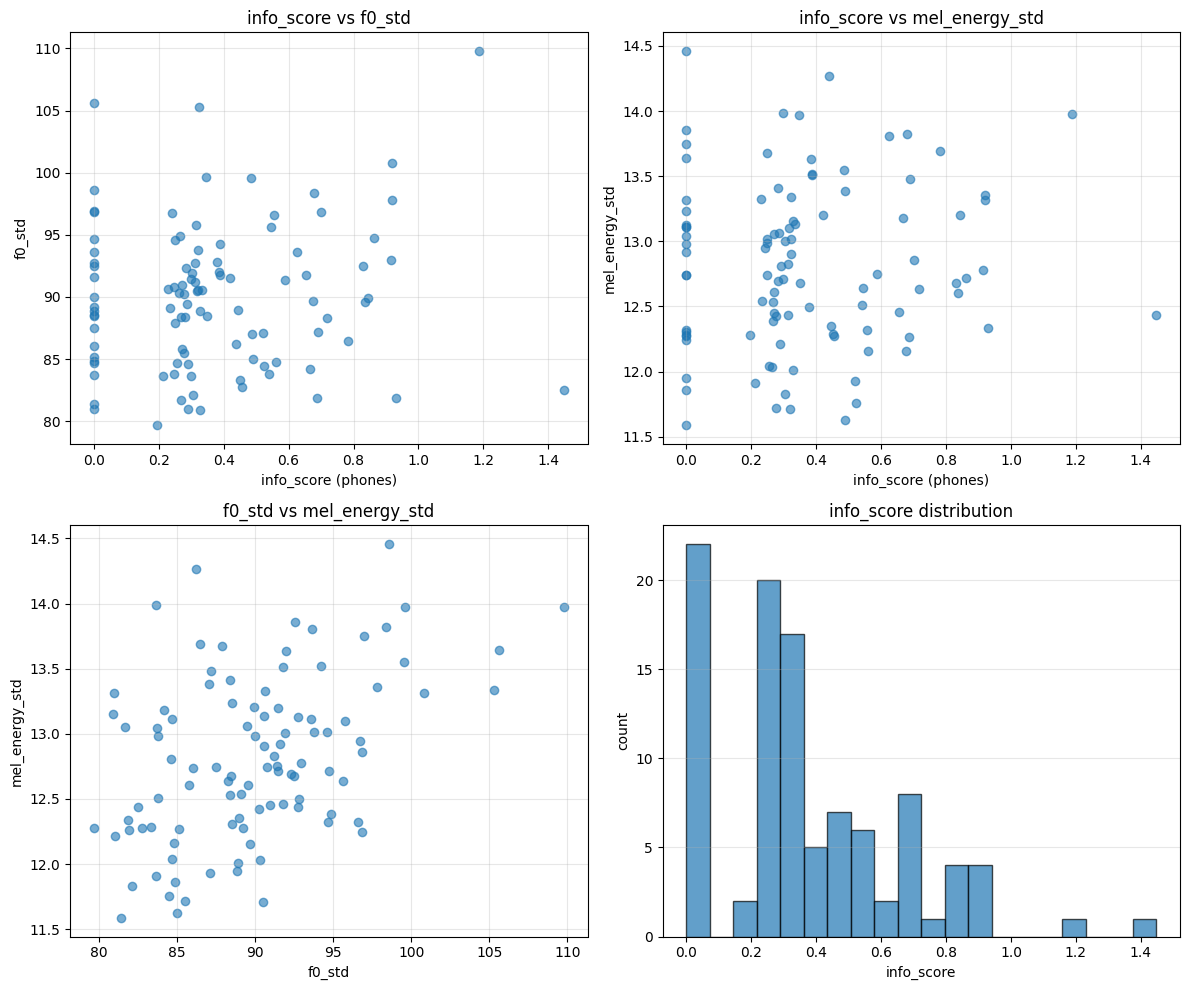

In [5]:
# 4. 特徴量の相関と分布をざっくり確認

numeric_cols = [
    "num_phones",
    "num_unique_phones",
    "rare_phone_count",
    "info_score",
    "mel_std",
    "mel_energy_std",
    "f0_std",
    "f0_range",
]

subset = feat_df[numeric_cols].dropna()

print("Correlation (subset):")
print(subset.corr()["info_score"][["mel_std", "mel_energy_std", "f0_std", "f0_range"]])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(feat_df['info_score'], feat_df['f0_std'], alpha=0.6)
axes[0, 0].set_xlabel('info_score (phones)')
axes[0, 0].set_ylabel('f0_std')
axes[0, 0].set_title('info_score vs f0_std')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].scatter(feat_df['info_score'], feat_df['mel_energy_std'], alpha=0.6)
axes[0, 1].set_xlabel('info_score (phones)')
axes[0, 1].set_ylabel('mel_energy_std')
axes[0, 1].set_title('info_score vs mel_energy_std')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].scatter(feat_df['f0_std'], feat_df['mel_energy_std'], alpha=0.6)
axes[1, 0].set_xlabel('f0_std')
axes[1, 0].set_ylabel('mel_energy_std')
axes[1, 0].set_title('f0_std vs mel_energy_std')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(feat_df['info_score'].dropna(), bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('info_score')
axes[1, 1].set_ylabel('count')
axes[1, 1].set_title('info_score distribution')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# 5. 特徴量密度スコアの定義

# min-max 正規化用のヘルパー
def minmax_norm(series: pd.Series) -> pd.Series:
    s = series.astype(float)
    if s.isna().all():
        return pd.Series([np.nan] * len(s), index=s.index)
    vmin = s.min()
    vmax = s.max()
    if vmax - vmin == 0:
        return pd.Series([0.0] * len(s), index=s.index)
    return (s - vmin) / (vmax - vmin)

feat_df['info_norm'] = minmax_norm(feat_df['info_score'])
feat_df['f0var_norm'] = minmax_norm(feat_df['f0_std'])
feat_df['melvar_norm'] = minmax_norm(feat_df['mel_energy_std'])

# 重み（とりあえず音素 0.4, F0 0.3, メル 0.3）
ALPHA = 0.4  # phones
BETA = 0.3   # f0
GAMMA = 0.3  # mel

feat_df['feature_score'] = (
    ALPHA * feat_df['info_norm'].fillna(0.0)
    + BETA * feat_df['f0var_norm'].fillna(0.0)
    + GAMMA * feat_df['melvar_norm'].fillna(0.0)
)

print("feature_score summary:")
print(feat_df['feature_score'].describe())


feature_score summary:
count    100.000000
mean       0.331880
std        0.139266
min        0.017352
25%        0.238190
50%        0.318682
75%        0.403122
max        0.877374
Name: feature_score, dtype: float64


In [7]:
# 6. 特徴量密度の高い文トップNを抽出

TOP_N = 10

feat_sorted = feat_df.sort_values('feature_score', ascending=False)
topN = feat_sorted.head(TOP_N).copy()

print(f"Top {TOP_N} sentences by feature_score:")
print(topN[['id', 'feature_score', 'info_score', 'f0_std', 'f0_range', 'mel_energy_std']].to_string(index=False))

print("\nTop sentences (id and text):")
for _, row in topN.iterrows():
    print(f"- {row['id']}: {row['text'][:60]}{'...' if len(str(row['text'])) > 60 else ''}")


Top 10 sentences by feature_score:
                 id  feature_score  info_score     f0_std   f0_range  mel_energy_std
VOICEACTRESS100_006       0.877374    1.187500 109.786367 450.000000       13.976160
VOICEACTRESS100_033       0.644648    0.918919 100.784773 450.000000       13.315879
VOICEACTRESS100_011       0.619448    0.920000  97.779565 450.000000       13.358288
VOICEACTRESS100_025       0.607567    0.679245  98.393422 440.229073       13.822988
VOICEACTRESS100_045       0.543770    0.625000  93.651830 438.140615       13.807659
VOICEACTRESS100_013       0.543339    0.346154  99.629518 415.394091       13.971120
VOICEACTRESS100_014       0.537018    0.484848  99.554519 450.000000       13.550689
VOICEACTRESS100_004       0.526989    0.322581 105.283431 450.000000       13.337421
VOICEACTRESS100_017       0.516942    1.448276  82.481363 370.219163       12.437723
VOICEACTRESS100_052       0.509069    0.914634  92.943864 450.000000       12.776262

Top sentences (id and text):


In [8]:
# 7. 結果の保存

FD_OUTPUT_DIR = OUTPUT_ROOT / "feature_density" / SPEAKER_ID
FD_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 全文の特徴量付きテーブル
feat_export = feat_df.copy()
# phones / unique_phones はすでに文字列 or リストとして入っているはずだが、念のため文字列化
if isinstance(feat_export.get('phones').iloc[0], list):
    feat_export['phones'] = feat_export['phones'].apply(lambda x: ' '.join(x))
if isinstance(feat_export.get('unique_phones').iloc[0], (set, list)):
    feat_export['unique_phones'] = feat_export['unique_phones'].apply(lambda x: ' '.join(sorted(list(x))))

feat_export.to_csv(FD_OUTPUT_DIR / "feature_density_corpus.csv", index=False, encoding='utf-8')

# 上位文だけ
topN.to_csv(FD_OUTPUT_DIR / "top_feature_sentences.csv", index=False, encoding='utf-8')

# サマリー
import json
summary = {
    "speaker_id": SPEAKER_ID,
    "top_n": TOP_N,
    "total_sentences": int(len(feat_df)),
    "selected_ids": topN['id'].tolist(),
}
with open(FD_OUTPUT_DIR / "summary.json", 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print(f"Saved feature-density results to: {FD_OUTPUT_DIR}")


Saved feature-density results to: /mnt/c/dev/minimal-feature-corpus-tts/outputs/feature_density/jvs002


## このノートで分かることまとめ

- 03の音素ベース解析 (`corpus_analysis.csv`) と 02の F0 / メル特徴量 (`*_f0.npy`, `*_mel.npy`) を統合して、
  各文ごとに **音素＋F0＋メル** の情報量を 1 つの `feature_score` として評価しました。
- `feature_score` 上位の文トップ10を「特徴量密度の高い少量コーパス候補」として `feature_density/top_feature_sentences.csv` に保存しています。
- 次のステップ（`04_tts_training.ipynb`）では、
  - フル100文
  - 03で得た音素ベース最小セット（4文）
  - このノートで得た特徴量密度トップ10
 など複数のコーパス条件で TTS モデルを学習し、
 `06_evaluation.ipynb` で品質を比較する、という実験設計に使えます。
